# This is a COVID-19 Model
## Important Notice, These are rough estimates. Please remember that no one can 100% be sure about what will happen.
This data model finds the peak of the number of COVID-19 cases, the number of people interacting, and the interaction rate among people. This data model is built in Python.

In [33]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Overview of the Data Model
1. First the model gets the data from csv files. You can download the csv files from kaggle.com
2. The model then processes the data.
3. The model then tunes params in a simulation function using nelder mead
    1. The params are InitialP, interaction_rate, population (population is the number of people who are interacting)
    2. The simulation function uses this equation to find the change in number of cases: $$\Delta p = \lambda p (1-p)$$ p = % of population infected, $\lambda$ = interaction rate
    3. It also used scipy.optimize.minimize, with method = nelder mead


In [34]:
# Imports
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import datetime as dt
import numpy as np
import json

## Getting and Processing the Data
To get the data we have many functions. The time_series function takes in what data you want and returns the location path of that data. "stringToDate" function takes a string and returns a date. This is used to turn a column (in pandas dataframe) from strings to dates.

In [35]:
def time_series(series_name):
    series_dir = "COVID-19-master/csse_covid_19_data/csse_covid_19_time_series"
    return(series_dir + "\\time_series_covid19_" + series_name + ".csv")

def stringToDate(x):
    return dt.datetime.strptime(x, '%m/%d/%y')

There is also another function: getStateData. The function getStateData takes in the state you want to get the data from and returns a dataframe where it has dates and all cases on that day. Here is another step by step explanation:
1. Get the confirmed_US data base, which has all the US state with an admin2
2. Find all rows where it contains the state.
3. Remove some unnecessary columns from the dataframe
4. Sum up all the columns so that we dont have the admin2 data, we want the state data
5. Reset the index of the dataframe
6. Apply stringToDate to the string dates
7. Set the index as the date column
8. Drop unnecessary columns
9. Rename columns to useful names

In [36]:
def getStateData(state): 
    data = pd.read_csv(time_series("confirmed_US"))
    state_data = data[data["Province_State"] == state]
    state_data = state_data.drop(columns=['Admin2', 'UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Country_Region', 'Lat', 'Long_', 'Province_State', 'Combined_Key'])
    state_data = state_data.sum(axis = 0, skipna = True)
    state_data = state_data.reset_index()
    state_data['date']=state_data['index'].apply(stringToDate)
    state_data = state_data.set_index('date')
    state_data=state_data.drop(columns=['index'])
    state_data=state_data.rename(columns={0:'confirmed'})
    return(state_data)

To get country data, we use getCountryData(). This is almost exactly the same as before, except one level up. (Level up means, admin2 -> state and state -> country)

In [37]:
def getCountryData(country):
    data = pd.read_csv(time_series("confirmed_global"))
    country_data = data[data["Country/Region"] == country]
    country_data = country_data.drop(columns = ['Province/State','Lat', 'Long', 'Country/Region'])
    country_data = country_data.sum(axis = 0, skipna = True)
    country_data = country_data.reset_index()
    country_data['date']=country_data['index'].apply(stringToDate)
    country_data = country_data.set_index('date')
    country_data=country_data.drop(columns=['index'])
    country_data=country_data.rename(columns={0:'confirmed'})
    return(country_data)

### Testing and Plotting data

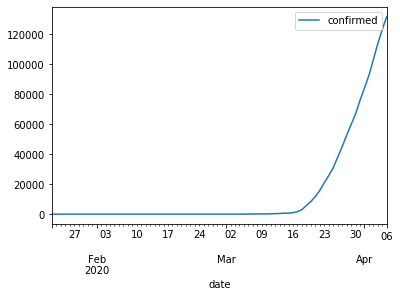

In [38]:
data = getStateData("New York")
data.plot()

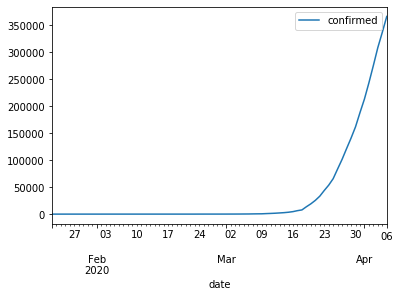

In [39]:
usdata = getCountryData("US")
usdata.plot()

## Simulating COVID-19 Interactions
We have a function that simulates the pandemic given the interaction rate, the starting date, the initial p, number of days to simulate, population which interacts. The most import thing is this formula: $$\Delta p = \lambda p (p-1)$$ 
1. Set variables to there corresponding values
    1. cases = [pInitial]
    2. dates = [start_date]
    3. p     = pInitial
2. Then we loop through the number of days
    1. Use this formula $\Delta p = \lambda p (p-1)$ and run that to find the new p
    2. Append $p u$ to cases
    3. Append the date of the day we are currently simulate to dates
3. Create a new dataframe using cases and dates 
<br /> p = percentage of the population that is infected, $\lambda$ is the interaction rate, u = population of the people who interact

In [40]:
def simulatePandemic(interaction_rate, start_date, pInitial = 1.2e-7, days = 90, population = 1408526449):
    cases = [pInitial]
    dates = [start_date]
    p     = pInitial
    
    for i in range(days):
        p += interaction_rate*p*(1-p)
        cases.append(p*population)
        dates.append(start_date+dt.timedelta(days=i))
    return(pd.DataFrame({'simulated':cases}, index = dates))

In [41]:
simulated_data = simulatePandemic(0.13, dt.datetime(2020,1,22).date(), days = 76)
data = pd.concat([usdata,simulated_data], axis=1, join='outer')

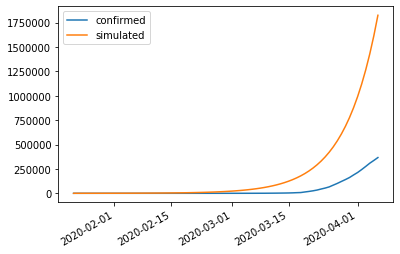

In [42]:
data.plot()

## Fitting the simulation params to different COVID-19 graphs

### Squared Error
We have function called squared error. This function params are a 3 dimensional vector X and data. It returns how off the vector was from simulating the data correctly. Here is a step by step explaination of what this function does:
1. Finds the starting date of the data.
2. Finds the number of days that is in the data (this is so we know how many days to simulate).
3. Call the simulatePandemic function and give it all the right params.
4. Connect both the real data (data) and the simulated data.
5. Subtract the real data from the simulated data to find the errors.
6. Return the sum of the errors squared.

In [43]:
def squared_error(X,data):
    start_date = list(data.index)[0]
    days = list(data.index)[-1] - start_date
    days = days.days
    simulated_data = simulatePandemic(X[1], start_date, pInitial = X[2], days = 76, population = X[0])
    this_data = pd.concat([data,simulated_data], axis=1, join='inner')
    this_data['diff'] = this_data['confirmed']-this_data['simulated']
    return sum(this_data['diff'].values **2) 
    

### Fit data
To fit the simulation to the data, we use scipys minimize function. We also use the nelder-mead method to minimize. This is a slow but working method. fit_data is a function that takes the data and x0. x0 is the starting value of the vector X that is used in the squared_error function. Another step by step explaination of what it does
1. Call the minimize function from scipy and give it the function squared_error and x0. We also set the method='nelder-mead' and we specify args = a tuple with data in it. We do this because the squared_error function requires "data" as a method. Finnally we also specify that we display some results in print and the max number of interations are 10000. (All of this is stored as res)
2. We set params as the the zeroth item in final_simplex which is in res
3. Due to the nelder mead method returning 4 points, we find an average of all four and return that

In [44]:
def fit_data(data, x0):
    res = minimize(squared_error, x0, method='nelder-mead', args=(data),options={'disp': True, 'maxiter':10000})
    params = res.final_simplex[0]
    params = sum(params)/len(params)
    return params

### Testing fit data on just one single country/state
After this we just tested some data. We currently have it set to fit New York

In [45]:
real_data = getStateData("New York")
x0 = [10* max(real_data['confirmed']) ,0.1, 0.02]
pop, inter_rate, initialP = fit_data(real_data, x0)

Optimization terminated successfully.
         Current function value: 158472642.324010
         Iterations: 575
         Function evaluations: 1016


As you can see below the fitting worked very well and it almost lined up with USA's data

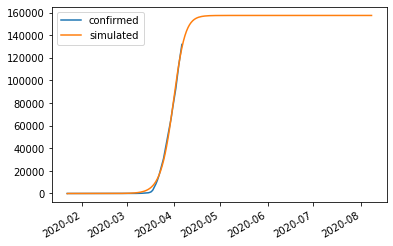

In [46]:
simulated_data = simulatePandemic(inter_rate, dt.datetime(2020,1,22).date(), pInitial = initialP, days = 200, population = pop)
data = pd.concat([real_data,simulated_data], axis=1, join='outer')
data.plot()

### Calculating the Peak of our estimated graphs
We have a very simple function to find the peak. The function calcPeak takes in "data" and returns None if there isn't a peak. If there is, it returns the date at which COVID-19 supposedly will peak. Here is another step by step explaination of what the function does:
1. Collects both dates and cases into a list
2. Finds the max number of cases
3. Loops through all the cases
    1. Checks if the number of cases is > 98% of the max number of cases. If True, return the date that the number of cases refers to.
4. If it never returns anything, we return None

In [47]:
def calcPeak(data):
    dates = list(data.index)
    cases = list(data['simulated'])
    max_case = max(cases)
    for i in range(len(cases)):
        if(cases[i] > 0.98*max_case):
            return(dates[i])
    return(None)

We tested the peak func below

In [48]:
peak = calcPeak(simulated_data)
peak

datetime.date(2020, 4, 15)

### Fitting simulation graphs to **ALL** state graphs
This is where everything all comes together. 
1. Define global_data, this is a dictionary that will be saved in a "save.json" file. It will contain state to (population, interaction rate, and the inital p)
2. Get all states/provinces
3. Loop through all states:
    1. Print the state that we are gonna fit right now
    2. Get the state data using getStateData method
    3. Set x0 as The max number of cases in that state X10, 0.1, 0.0002
    4. Fit the data and store it in pop, inter_rate, initialP variables
    5. Simulate the Pandemic with the settings that fit_data gave us (We simulate for 150 days so we know where the peak is)
    6. Get the peak from the simulated data
    7. Add the new data that we found to global_data
    8. Save global_data in the save.json

In [18]:
global_data = {}
all_states = list(set(pd.read_csv(time_series("confirmed_US"))['Province_State']))
for state in all_states:
    print(state)
    real_data = getStateData(state)
    x0 = [10* max(real_data['confirmed']),0.1, 0.0002]
    pop, inter_rate, initialP = fit_data(real_data, x0)
    sim_data = simulatePandemic(inter_rate, dt.datetime(2020,1,22).date(), pInitial = initialP, days = 150, population = pop)
    peak = calcPeak(sim_data)
    print(inter_rate)
    global_data[state] = pop, inter_rate, peak.strftime('%m/%d/%y')
    save_file = open('save.json', 'w')
    json.dump(global_data, save_file)
    save_file.close()

Puerto Rico
Optimization terminated successfully.
         Current function value: 5060.216426
         Iterations: 667
         Function evaluations: 1149
0.33048566382202577
Grand Princess
Optimization terminated successfully.
         Current function value: 4967.851230
         Iterations: 586
         Function evaluations: 1021
0.3892735450745207
New Jersey
Optimization terminated successfully.
         Current function value: 6168550.202061
         Iterations: 607
         Function evaluations: 1047
0.2996770675926043
California
Optimization terminated successfully.
         Current function value: 625566.793900
         Iterations: 412
         Function evaluations: 729
0.22048131676230606
Maryland
Optimization terminated successfully.
         Current function value: 30589.264107
         Iterations: 548
         Function evaluations: 951
0.2643791482247502
New Mexico
Optimization terminated successfully.
         Current function value: 7206.211406
         Iterations: 366
  

C:\Users\sujay\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys


Optimization terminated successfully.
         Current function value: 59862.314851
         Iterations: 437
         Function evaluations: 755
0.24347108944484208
Nevada
Optimization terminated successfully.
         Current function value: 30202.695151
         Iterations: 501
         Function evaluations: 859
0.28879169930955306
Nebraska
Optimization terminated successfully.
         Current function value: 1348.578952
         Iterations: 360
         Function evaluations: 628
0.1783882928692192
American Samoa
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 55
         Function evaluations: 101
0.13715504329656936
Rhode Island
Optimization terminated successfully.
         Current function value: 7735.058846
         Iterations: 434
         Function evaluations: 763
0.24695734998882352
Arizona
Optimization terminated successfully.
         Current function value: 41002.272680
         Iterations: 692
         Function evaluatio

### Loading the data that was found in the simulations and analizing it
Here we take our save and we load it. We then proceed to change to a form that is easy to analize. Here is a step by step explaination of what we do here.
1. Open the save.json file and store it as "s"
2. Turn the json loaded save file and turn it into a pandas dataframe (this is stored as state_data)
3. Then rotate the dataframe 90 degrees
4. Reset the index of the dataframe
5. Rename columns from the data frame to more sensible names (index, 0, 1, 2 to State, Population, Interaction Rate, Peak Date)
6. Set the index to the state column
7. Apply stringToDate to the Peak Date column because the json file saved dates as a string and so we have to turn it back

In [49]:
with open('save.json') as s:
    state_data = pd.DataFrame(json.load(s))
    
    state_data = state_data.transpose()
    state_data = state_data.reset_index()
    state_data = state_data.rename(columns={'index':'State', 0:'Population',1:'Interaction Rate',2:'Peak Date'})
    state_data = state_data.set_index('State')
    state_data['Peak Date'].apply(stringToDate)

Here we have sorted the dataframe by the Interaction Rate. This basicly shows how much they are interacting.

In [50]:
state_data.sort_values(by=['Interaction Rate'],ascending=False)

,Population,Interaction Rate,Peak Date
State,,,
Northern Mariana Islands,5.99919,3.19108,04/29/20
Diamond Princess,48.9074,1.76196,03/18/20
Idaho,1271.47,0.399667,04/10/20
Grand Princess,109.628,0.389274,04/04/20
Alaska,169.104,0.363923,04/07/20
Puerto Rico,651.883,0.330486,04/13/20
Indiana,6329.52,0.306776,04/14/20
Missouri,3146.58,0.305789,04/13/20
West Virginia,429.399,0.304555,04/14/20


Here we sort the data by the Peak Date, this date should be when the COVID-19 will stop growing so rapidly.

In [51]:
state_data.sort_values(by=['Peak Date'],ascending=False)

,Population,Interaction Rate,Peak Date
State,,,
American Samoa,1.49384e-05,0.137155,06/19/20
Nebraska,2450.64,0.178388,05/06/20
New Hampshire,2481.27,0.184045,05/01/20
Delaware,3277.98,0.196864,05/01/20
New Mexico,2691.63,0.200723,04/29/20
Northern Mariana Islands,5.99919,3.19108,04/29/20
Virgin Islands,99.3285,0.177269,04/28/20
South Dakota,861.463,0.205377,04/28/20
Washington,11541.2,0.172391,04/23/20
